In [139]:
import sys

import numpy as np

sys.path.append('../') 
from imports import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
import seaborn as sns



In [120]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [121]:
torch.cuda.is_available()

True

In [132]:
import pandas as pd


# loading processed data
df_train = pd.read_csv('./uci-adult-processed-data/train.csv')
df_val = pd.read_csv('./uci-adult-processed-data/val.csv')
df_test = pd.read_csv('./uci-adult-processed-data/test.csv')

# Define your features and target variable
target_column = 'target' 
features = df_train.columns.drop(target_column)

# Separate features and target
X_train = df_train[features]
y_train = df_train[target_column]
X_val = df_val[features]
y_val = df_val[target_column]
X_test = df_test[features]
y_test = df_test[target_column]

# Initialize the StandardScaler
scaler = StandardScaler()
# scaler = MinMaxScaler()
# Fit the scaler on the training data and transform the training data
X_train = scaler.fit_transform(X_train)

# Transform the validation and test data
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to NumPy arrays (if needed)
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()


In [133]:
# Convert Numpy arrays to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create dataloaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=1)

In [134]:
class FNN(nn.Module):
    def __init__(self, input_size):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [135]:
model = FNN(X_train.shape[1]).to(device)
criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [136]:
def calculate_accuracy(y_pred, y_true):
    # Convert predictions to binary values (0 or 1)
    
    predicted = torch.round(y_pred).view(-1)
    y_true = y_true.squeeze()
    return (predicted == y_true).sum().float() / len(y_true)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
# Training and validation for certain epochs
epochs = 50
for epoch in range(epochs):  # number of epochs
    model.train()
    total_loss, total_acc = 0, 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += calculate_accuracy(output, target)
        
    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = total_acc / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    
    # Validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            val_loss += criterion(output, target).item()
            val_acc += calculate_accuracy(output, target)
            
    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}')



Epoch 1, Training Loss: 0.5394, Training Accuracy: 0.7585, Validation Loss: 0.4514, Validation Accuracy: 0.8002
Epoch 2, Training Loss: 0.4212, Training Accuracy: 0.8129, Validation Loss: 0.3979, Validation Accuracy: 0.8190
Epoch 3, Training Loss: 0.3897, Training Accuracy: 0.8213, Validation Loss: 0.3787, Validation Accuracy: 0.8247
Epoch 4, Training Loss: 0.3748, Training Accuracy: 0.8264, Validation Loss: 0.3663, Validation Accuracy: 0.8303
Epoch 5, Training Loss: 0.3648, Training Accuracy: 0.8302, Validation Loss: 0.3565, Validation Accuracy: 0.8343
Epoch 6, Training Loss: 0.3566, Training Accuracy: 0.8333, Validation Loss: 0.3488, Validation Accuracy: 0.8364
Epoch 7, Training Loss: 0.3504, Training Accuracy: 0.8358, Validation Loss: 0.3429, Validation Accuracy: 0.8393
Epoch 8, Training Loss: 0.3454, Training Accuracy: 0.8386, Validation Loss: 0.3384, Validation Accuracy: 0.8427
Epoch 9, Training Loss: 0.3419, Training Accuracy: 0.8403, Validation Loss: 0.3351, Validation Accuracy:

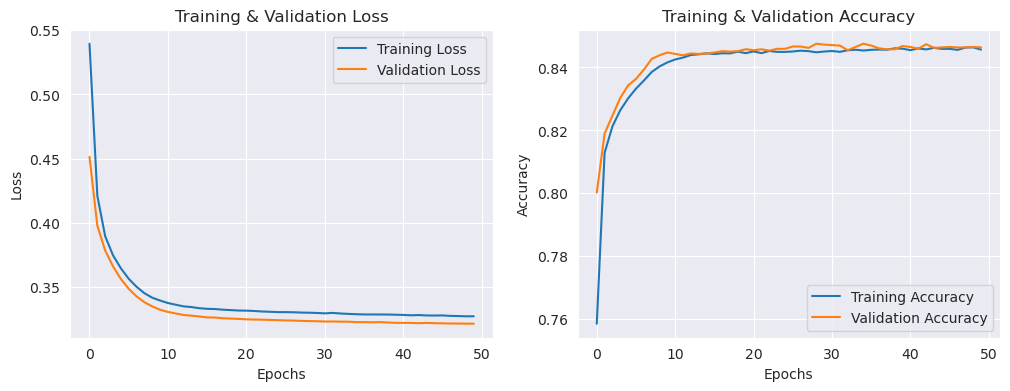

In [137]:
import matplotlib.pyplot as plt

# Plotting training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
train_accuracies = [acc.cpu().numpy() for acc in train_accuracies]
val_accuracies = [acc.cpu().numpy() for acc in val_accuracies]

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [138]:
# Testing the model
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        output = output.squeeze(1)
        test_loss += criterion(output, target).item()

        # For accuracy calculation
        predicted = torch.round(output).view(-1)  # Assuming binary classification
        correct += (predicted == target).sum().item()
        total += target.size(0)

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.3338, Test Accuracy: 84.57%


In [104]:
# Now let us perform hyperparamter tuning to find optimal parameters and replace them where needed!
# Defining the parametr grid for hyperparameter tuning
param_grid = {
    'lr': [0.0001, 0.001, 0.01],
    'batch_size': [32, 64],
    'epochs': [15, 50]
}

In [105]:
def calculate_accuracy(y_pred, y_true):
    # Convert predictions to binary values (0 or 1)
    y_pred, y_true = y_pred.squeeze(), y_true.squeeze()
    predicted = torch.round(y_pred).view(-1)
    return (predicted == y_true).sum().float() / len(y_true)

In [106]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, total_acc = 0, 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data).squeeze()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_acc += calculate_accuracy(output, target)
            
        avg_train_loss = total_loss / len(train_loader)
        avg_train_acc = total_acc / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)

        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data).squeeze()
                val_loss += criterion(output, target).item()
                val_acc += calculate_accuracy(output, target)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)

    return avg_val_loss, avg_val_acc


In [107]:
best_val_acc = 0
best_params = {}

for params in ParameterGrid(param_grid):
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=params['batch_size'])

    model = FNN(X_train.shape[1]).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])

    val_loss, val_acc = train_and_validate(model, train_loader, val_loader, criterion, optimizer, params['epochs'])

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params

    print(f"Params: {params}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}%")

print(f"Best Params: {best_params}, Best Validation Accuracy: {best_val_acc:.4f}%")


Params: {'batch_size': 32, 'epochs': 15, 'lr': 0.0001}, Validation Loss: 0.3272, Validation Accuracy: 0.8452%
Params: {'batch_size': 32, 'epochs': 15, 'lr': 0.001}, Validation Loss: 0.3173, Validation Accuracy: 0.8520%
Params: {'batch_size': 32, 'epochs': 15, 'lr': 0.01}, Validation Loss: 0.3470, Validation Accuracy: 0.8471%
Params: {'batch_size': 32, 'epochs': 50, 'lr': 0.0001}, Validation Loss: 0.3217, Validation Accuracy: 0.8477%
Params: {'batch_size': 32, 'epochs': 50, 'lr': 0.001}, Validation Loss: 0.3306, Validation Accuracy: 0.8504%
Params: {'batch_size': 32, 'epochs': 50, 'lr': 0.01}, Validation Loss: 0.3472, Validation Accuracy: 0.8490%
Params: {'batch_size': 64, 'epochs': 15, 'lr': 0.0001}, Validation Loss: 0.3326, Validation Accuracy: 0.8453%
Params: {'batch_size': 64, 'epochs': 15, 'lr': 0.001}, Validation Loss: 0.3202, Validation Accuracy: 0.8498%
Params: {'batch_size': 64, 'epochs': 15, 'lr': 0.01}, Validation Loss: 0.3438, Validation Accuracy: 0.8502%
Params: {'batch_siz

In [110]:
model = FNN(X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Convert Numpy arrays to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create dataloaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=1)

def calculate_accuracy(y_pred, y_true):
    # Convert predictions to binary values (0 or 1)

    predicted = torch.round(y_pred).view(-1)
    y_true = y_true.squeeze()
    return (predicted == y_true).sum().float() / len(y_true)


train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
# Training and validation for certain epochs
epochs = 15
for epoch in range(epochs):  # number of epochs
    model.train()
    total_loss, total_acc = 0, 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += calculate_accuracy(output, target)

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = total_acc / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            val_loss += criterion(output, target).item()
            val_acc += calculate_accuracy(output, target)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    print(
        f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {avg_train_acc:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}')



/tmp/ipykernel_5761/1516699542.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
/tmp/ipykernel_5761/1516699542.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
/tmp/ipykernel_5761/1516699542.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torc

Epoch 1, Training Loss: 0.3856, Training Accuracy: 0.8219, Validation Loss: 0.3349, Validation Accuracy: 0.8421
Epoch 2, Training Loss: 0.3372, Training Accuracy: 0.8422, Validation Loss: 0.3266, Validation Accuracy: 0.8468
Epoch 3, Training Loss: 0.3334, Training Accuracy: 0.8443, Validation Loss: 0.3243, Validation Accuracy: 0.8458
Epoch 4, Training Loss: 0.3321, Training Accuracy: 0.8456, Validation Loss: 0.3226, Validation Accuracy: 0.8479
Epoch 5, Training Loss: 0.3306, Training Accuracy: 0.8453, Validation Loss: 0.3229, Validation Accuracy: 0.8455
Epoch 6, Training Loss: 0.3297, Training Accuracy: 0.8451, Validation Loss: 0.3222, Validation Accuracy: 0.8448
Epoch 7, Training Loss: 0.3286, Training Accuracy: 0.8455, Validation Loss: 0.3220, Validation Accuracy: 0.8476
Epoch 8, Training Loss: 0.3277, Training Accuracy: 0.8450, Validation Loss: 0.3209, Validation Accuracy: 0.8489
Epoch 9, Training Loss: 0.3266, Training Accuracy: 0.8472, Validation Loss: 0.3191, Validation Accuracy:

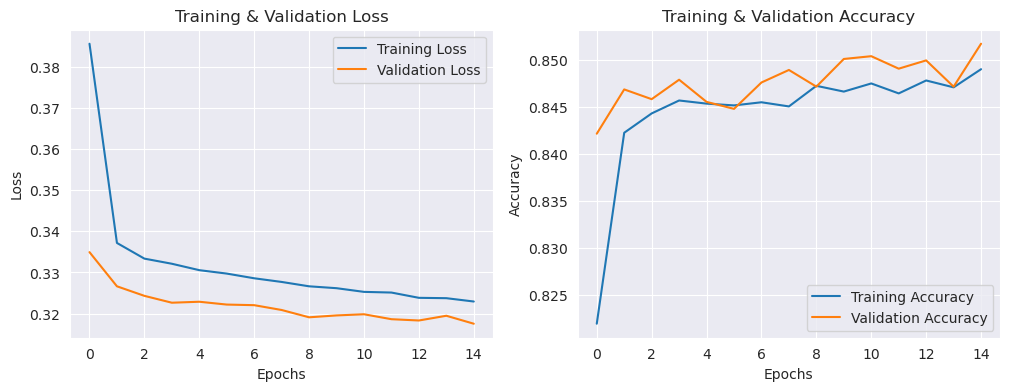

In [111]:

# Plotting training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
train_accuracies = [acc.cpu().numpy() for acc in train_accuracies]
val_accuracies = [acc.cpu().numpy() for acc in val_accuracies]

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()




In [141]:
# Testing the model
model.eval()
test_loss = 0
correct = 0
total = 0
y_true = y_test
y_pred = []
y_scores = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data).squeeze(1)
        y_scores.extend(output.cpu().numpy().flatten())
        test_loss += criterion(output, target).item()

        # For accuracy calculation
        predicted = torch.round(output).view(-1)  # Assuming binary classification
        y_pred.append(predicted)
        
        correct += (predicted == target).sum().item()
        total += target.size(0)
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.3338, Test Accuracy: 84.57%


In [142]:
y_true = np.array(y_true)

In [143]:
y_pred = [pred.to('cpu') for pred in y_pred]

In [144]:
y_pred = np.array(y_pred)

In [145]:
y_pred.shape

(6784, 1)

[[4708  395]
 [ 652 1029]]


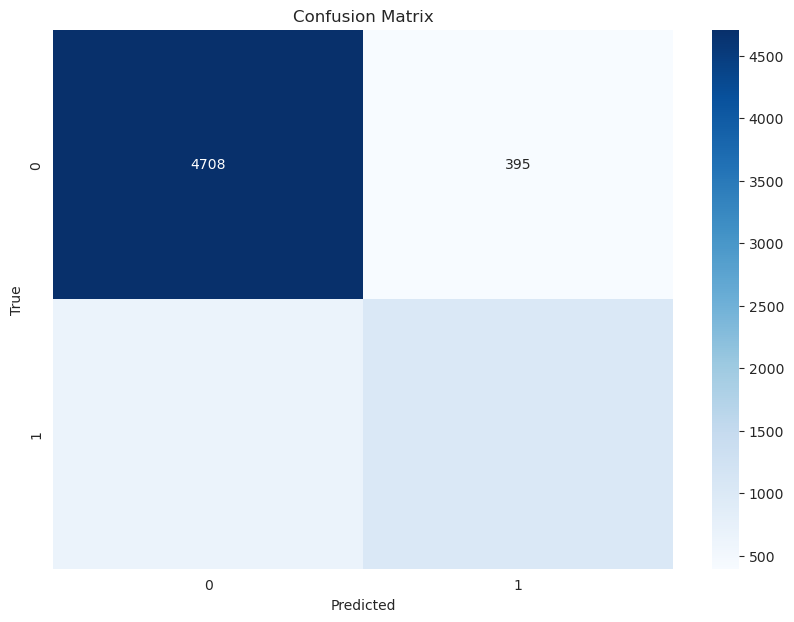

In [146]:

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


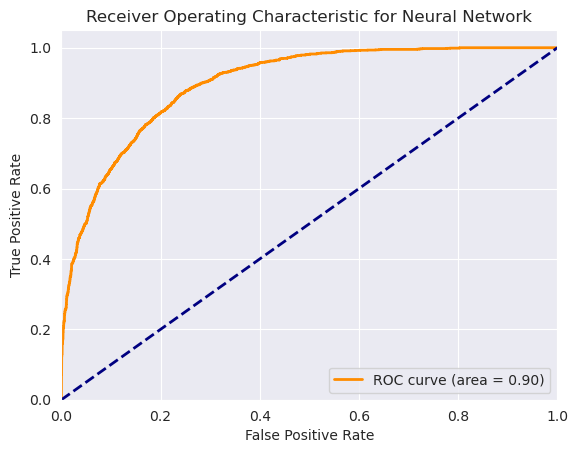

In [147]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Neural Network')
plt.legend(loc="lower right")
plt.show()